In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
%load_ext autoreload

import jax
import jax.numpy as jnp
from jax import random, vmap, jit, grad


import optax
import torch.utils.data as data
from flax import linen as nn

from functools import partial
import itertools
from tqdm.auto import trange
import matplotlib.pyplot as plt


from typing import (Any, Callable, Iterable, List, Optional, Sequence, Tuple,
                    Union)

In [3]:
from train_utils import BatchedDataset, Operator
from archs import RPNEnsemble, RingEncoding, MonotonicActuator, identity, MLP, Actuator

## Loading Data

In [4]:
import pickle

In [5]:
data_name = 'model_data_dictionary_N_Pa.pkl'
data_dict = pickle.load(open(data_name, 'rb'))

In [6]:
## Preparing dataset
# read membrane names
membranes = []
for key in data_dict.keys():
    # split the key by comma, drop spaces and brackets
    key_split = key.split(',')
    key_split = [x.replace('[','').replace(']','').replace(' ','') for x in key_split]
    key_split = [float(x) for x in key_split]   
    membranes.append(key_split)

# describing dataset
num_membranes = len(data_dict)
print(f"In total there are {num_membranes} distinct membranes.")

def join_datasets(ds):
    # unpack quantities
    us = [d[0][0] for d in ds]
    ys = [d[0][1] for d in ds]
    fs = [d[1] for d in ds]
    ws = [d[2] for d in ds]
    
    # join quantities of interest
    us = jnp.concatenate(us)
    ys = jnp.concatenate(ys)
    fs = jnp.concatenate(fs)
    ws = jnp.concatenate(ws)

    return (us, ys), fs, ws

all_data = join_datasets(data_dict.values())
(us, ys), fs, ws = all_data

In total there are 22 distinct membranes.


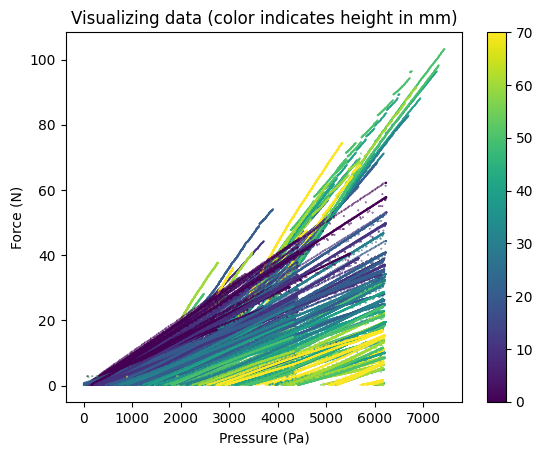

In [7]:
hs = us[:,0]
plt.scatter(ys, fs, c=hs, s=0.1)
plt.xlabel('Pressure (Pa)')
plt.ylabel('Force (N)')
plt.colorbar()
plt.title("Visualizing data (color indicates height in mm)")
plt.show()

## Training Model

In [8]:
# define architecture
ensemble_size = 32
ring_encoder = RingEncoding(24, identity)
latent_encoder = MLP([16,16,16,16], activation=nn.gelu)
arch = MonotonicActuator(
# arch = Actuator(
    ring_encoder,
    latent_encoder,
    polynomial_degree=1,
    output_activation=nn.leaky_relu,
)
ensemble = RPNEnsemble(arch, ensemble_size=ensemble_size)

In [9]:
# create data loader
init_data_loader = BatchedDataset(all_data, key=random.PRNGKey(58), batch_size=10_000, has_weights=True)
# fetch initial batch to initialize model and check loader
init_batch = next(iter(init_data_loader))

# Define ensemble
ensemble = RPNEnsemble(arch, ensemble_size)

print('Initializing model...')
model = Operator(ensemble, init_batch, has_weights=True, huber_delta=1., key=random.key(24)) #start model
print(model.tabulate())

Initializing model...

                                             RPNEnsemble Summary                                              
┌──────────────────────┬───────────────────┬────────────────────┬─────────────────────┬──────────────────────┐
│ path                 │ module            │ inputs             │ outputs             │ params               │
├──────────────────────┼───────────────────┼────────────────────┼─────────────────────┼──────────────────────┤
│                      │ RPNEnsemble       │ - float32[10000,7] │ float32[32,10000,1] │                      │
│                      │                   │ - float32[10000,1] │                     │                      │
├──────────────────────┼───────────────────┼────────────────────┼─────────────────────┼──────────────────────┤
│ OperatorEnsemble_0   │ OperatorEnsemble  │ - float32[10000,7] │ float32[64,10000,1] │                      │
│                      │                   │ - float32[10000,1] │                     │  

In [15]:
# train model
num_steps = 10_000
data_loader = BatchedDataset(all_data, key=random.PRNGKey(58), batch_size=100, has_weights=True)
model.train(data_loader, nIter=num_steps)

100%|██████████| 10000/10000 [34:52<00:00,  4.78it/s, loss=0.78844374, grad_norm=1.0064887]  


## Acquisition

In [10]:
%autoreload 2
from acquisition import MCAcquisition
from design_optimization import get_rw, opt_var_to_phys_var, print_recommendations

In [11]:
# Parameters for material
_radius = 70. # radius of the entire membrane
_min_spacing = 3. # minimum spacing between rings and other rings/boundaries
_min_width = 5. # minimum width of each ring

_tmin = 1. # minimum membrane thickness
_tmax = 3. # maximum membrane thickness
_contactmin = 25.4 # minimum contact disk radius
_contactmax = 38.1  # maximum contact disk radius

### Setup

In [12]:
def get_posterior_fn(model, num_rings, hs, pmin, pmax, num_ps, max_rings=2, tmin=_tmin, tmax=_tmax, contactmin=_contactmin, contactmax=_contactmax):
    
    # computing bounds
    lb = jnp.array([tmin, contactmin] + 2*num_rings*[0.])
    ub = jnp.array([tmax, contactmax]+ 2*num_rings*[1.])

    # function to compute posterior function
    def posterior(membrane_coefs):
        # membrane_coefs is a vector with up to 6 entries: t, w0, r1, w1, r2, w2
        '''
        material_params = membrane_coefs[:2]
        ring_params = jnp.concatenate([membrane_coefs[2:], jnp.array(2*(max_rings-num_rings)*[jnp.nan])])
        ring_params = get_rw(material_params[1], ring_params, num_rings)

        membrane = jnp.concatenate([material_params, ring_params])
        '''

        membrane = opt_var_to_phys_var(membrane_coefs, num_rings, max_rings)

        #preparing us
        us = [jnp.concatenate([jnp.array([h]), membrane])[None,:] for h in hs] # list of num_hs vectors of shape (1, 7) each
        us = [jnp.tile(u, (num_ps, 1)) for u in us] # list of num_hs vectors of shape (num_ps, 7) each
        us = jnp.concatenate(us) # shape (num_ps*num_hs, 7)

        # preparing pressures
        ys = jnp.linspace(pmin, pmax, num_ps)[:,None] # shape (num_ps, 1)
        ys = jnp.tile(ys, (len(hs),1)) # shape (num_ps*num_hs, 1)

        # making predictions
        samples = model.apply(model.params, us, ys) # shape (num_ensembles, num_ps*num_hs, 1)
        return samples
    # returns posterior function and bounds for optimization
    return posterior, (lb, ub)

In [13]:
# you probably don't need to change these values
#hs = set(data.nominal_height.values)
hs = jnp.linspace(0, 30., 4)
pmin = 0.
pmax = 3.
num_ps = 20

### Selecting next experiments

In [16]:
q = 2 # number of membranes to be collected next
seed = 3 # change this to alter RNG of initial guesses

recs = []
objs = []
for num_rings in range(3):
    posterior, bounds = get_posterior_fn(model, num_rings, hs, pmin, pmax, num_ps)
    acquisition = MCAcquisition(vmap(posterior), bounds)
    print(f"Determining best membranes to test using {num_rings} rings...")
    u_new = acquisition.next_best_point(q, num_restarts=1_000, seed=seed)
    u_new = vmap(opt_var_to_phys_var, in_axes=(0,None))(u_new.reshape((q,-1)), num_rings)
    recs.append(u_new.copy())
    objs.append(acquisition.evaluate(u_new))

Determining best membranes to test using 0 rings...


100%|██████████| 1000/1000 [06:30<00:00,  2.56it/s]


Determining best membranes to test using 1 rings...


100%|██████████| 1000/1000 [17:53<00:00,  1.07s/it]


Determining best membranes to test using 2 rings...


100%|██████████| 1000/1000 [22:21<00:00,  1.34s/it] 


In [17]:
best_num_rings = jnp.argmin(jnp.array(objs))
print(f'The recomendation is to make membranes with {best_num_rings} rings.')
print(f'Here are the recomendations:')
print_recommendations(recs[best_num_rings])

The recomendation is to make membranes with 2 rings.
Here are the recomendations:

Membrane:
thickness:  2.33
contact radius:  33.55
Ring 1) radius:  41.55; width:  5.00
Ring 2) radius:  54.64; width:  5.09

Membrane:
thickness:  1.00
contact radius:  25.40
Ring 1) radius:  34.81; width:  6.41
Ring 2) radius:  55.61; width:  11.39


In [18]:
print("Here are the recommendations considering all possibilities.")
print("Higher acquisition scores indicate higher epistemic uncertainty.")
for num_rings in range(3):
    print('\n------------------\n')
    print(f'Using {num_rings} rings (acquisition score is {-objs[num_rings] : .2f}):')
    print_recommendations(recs[num_rings])

Here are the recommendations considering all possibilities.
Higher acquisition scores indicate higher epistemic uncertainty.

------------------

Using 0 rings (acquisition score is  0.55):

Membrane:
thickness:  2.59
contact radius:  29.71

Membrane:
thickness:  3.00
contact radius:  38.10

------------------

Using 1 rings (acquisition score is  2.03):

Membrane:
thickness:  1.00
contact radius:  25.40
Ring 1) radius:  47.70; width:  19.30

Membrane:
thickness:  2.84
contact radius:  38.10
Ring 1) radius:  46.63; width:  5.53

------------------

Using 2 rings (acquisition score is  2.32):

Membrane:
thickness:  2.33
contact radius:  33.55
Ring 1) radius:  41.55; width:  5.00
Ring 2) radius:  54.64; width:  5.09

Membrane:
thickness:  1.00
contact radius:  25.40
Ring 1) radius:  34.81; width:  6.41
Ring 2) radius:  55.61; width:  11.39
